# Simulate data using behavioral model and perform parameter recovery

There are 3 models with different parameter combinations:

1. <b>The Bayesian model (Schwöbel et al. 2021):</b> \
   <b>a.</b> With 3 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, and a decision temparature $\beta$. \
   <b>b.</b> With 4 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, a decision temparature $\beta$, and a habitual tendency $h$.
2. <b>A newer MF/MB version that is better for fitting (Otto et al. 2013):</b> \
<b>Note:</b> This is not quite the original version, as the Q-values in the original work did not converge to the true expected values. Instead, I implemented a "bug-fixed" version.\
   <b>a.</b> With 4 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$$, and a repetition/perserveration parameter $p$. \
3. <b>The original model-free/model-based (MF/MB) model (Daw et al. 2005, 2011):</b> \
   <b>a.</b> With 4 parameters: a weighting parameters $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a weighting parameter $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, a dicount factor $\lambda$, and a repetition/perserveration parameter $p$.

Tell python that the code in the submodule is code that we want to import and run

In [1]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf
import inference_utils as iu

torch threads 1
Running on device cpu
torch threads 1


Other imports that we need for simulation, inference, and plotting

In [2]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
#import jsonpickle as pickle
import json
import gc
import pickle

Where second stage random walks from the experiment are stored

In [3]:
Rho_data_fname = os.path.join("experiment", "dawrandomwalks.mat")

Define where results should be saved

In [4]:
results_folder = os.path.join(current_dir, "results")
simulation_folder = os.path.join(results_folder, "simulations")
cross_fitting_folder = os.path.join(results_folder, "cross_fitting")

mask_file_name = "mask.txt"
processed_data_folder = os.path.join("processed_data")
mask_file = os.path.join(processed_data_folder, mask_file_name)

#### Global experiment parameters

In [5]:
# number of simulated agents/participants
n_agents = 188

In [6]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, "rb") as f:
    all_mask = pickle.load(f)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask).permute((1,0))
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.9766)


/tmp/ipykernel_3002/1544998221.py:15: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  exp_mask = torch.tensor(all_mask).permute((1,0))


Define states and transition matrices

In [7]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

Load and plot reward probabilities

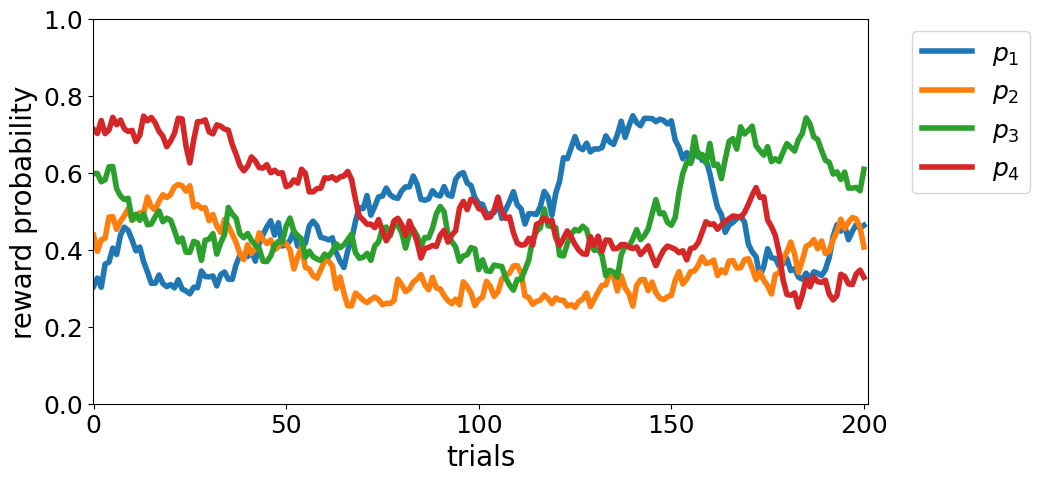

In [8]:
rew_probs = loadmat(Rho_data_fname)['dawrandomwalks']
assert trials==rew_probs.shape[-1]

Rho = torch.zeros((trials, nr, ns))

Rho[:,1,:never_reward] = 0.
Rho[:,0,:never_reward] = 1.

Rho[:,1,never_reward:never_reward+2] = torch.from_numpy(rew_probs[0,:,:]).permute((1,0))
Rho[:,0,never_reward:never_reward+2] = torch.from_numpy(1-rew_probs[0,:,:]).permute((1,0))

Rho[:,1,never_reward+2:] = torch.from_numpy(rew_probs[1,:,:]).permute((1,0))
Rho[:,0,never_reward+2:] = torch.from_numpy(1-rew_probs[1,:,:]).permute((1,0))

plt.figure(figsize=(10,5))
for i in range(4):
    plt.plot(Rho[:,1,3+i], label="$p_{}$".format(i+1), linewidth=4)
plt.ylim([0,1])
plt.yticks(torch.arange(0,1.1,0.2),fontsize=18)
plt.ylabel("reward probability", fontsize=20)
plt.xlim([-0.1, trials+0.1])
plt.xticks(range(0,trials+1,50),fontsize=18)
plt.xlabel("trials", fontsize=20)
plt.legend(fontsize=18, bbox_to_anchor=(1.04,1))
plt.savefig(os.path.join(results_folder, "twostep_prob.svg"),dpi=300)
plt.show()

# add to parameter dict
global_experiment_parameters["Rho"] = Rho

Now we can start :) 

Load stored simulation results of BCC3

Simulation pre-setup

In [9]:
# set parameters and their names

learn_rewards = True
learn_habit = False
use_h = False
learn_cached = False

param_names = []
param_ranges = []

prefix = "BCC"
model_name = "Bayesian prior-based contextual control model"
n_pars = 0
agnt_str = ""

if learn_rewards:
    n_pars += 2
    param_names += ["dec temp", "reward rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_plan"

if learn_habit:
    # infer_h = True
    # infer_policy_rate = True 
    n_pars += 2
    agnt_str += "_habit"
    param_names += ["habitual tendency", "policy rate"]
    if use_h:
        agnt_str += "_h"
        param_ranges += [[0,1], [0,1]]
    else:
        agnt_str += "_weight"
        param_ranges += [[0,8], [0,1]]
# else:
#     infer_h = False
#     infer_policy_rate = False

if learn_cached:
    n_pars += 2
    param_names += ["cached weight", "cached rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_cached"

assert n_pars > 0, "please turn any part of the agent on, it cannot run without any learning or inference."

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
agent_type = prefix+"_"+str(n_pars)+"pars"+agnt_str+"_NO_context"
print(agent_type)
fname_base = agent_type+"_simulation_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(simulation_folder,fname_base[:-1])

BCC_2pars_plan_NO_context
BCC_2pars_plan_NO_context_simulation_


In [10]:
print("loading simulated outputs...")

stayed_arr, true_vals, data = tu.load_simulation_outputs(base_dir, agent_type)

n_true = true_vals["subject"].max() + 1
n_data = data["subject"].max() + 1

assert n_true == n_data == n_agents, f"the numbers of agents dont match! They are: {n_true}, {n_data}, {n_agents}. Probably rerun simulations to fix."

print("true values are:")
print(true_vals)

loading simulated outputs...
true values are:
{'subject': tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,

Plot simulated stay probability

/tmp/ipykernel_3002/3682874209.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(bar_names, rotation=45, horizontalalignment='right', fontsize=16)


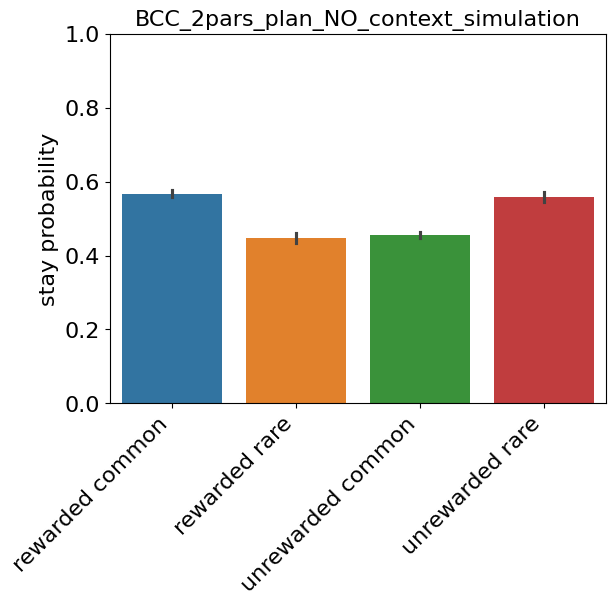

In [11]:
bar_names = ["rewarded common", "rewarded rare", "unrewarded common", "unrewarded rare"]

plt.figure()
g = sns.barplot(data=stayed_arr)
g.set_xticklabels(bar_names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0,1])
plt.yticks(torch.arange(0,1.1,0.2),fontsize=16)
plt.ylabel("stay probability", fontsize=16)
plt.title(fname_base[:-1], fontsize=16)
plt.savefig(os.path.join(base_dir,"simulated_stay_probs.svg"),dpi=300)
plt.show()

#### Inference: we will analyze BCC2_planning data with the BCC4_planning_repetition model

Simulation pre-setup

In [12]:
# set parameters and their names

learn_rewards = True
learn_habit = True
use_h = False
learn_cached = True

param_names = []
param_ranges = []

prefix = "BCC"
model_name = "Bayesian prior-based contextual control model"
n_pars = 0
agnt_str = ""

if learn_rewards:
    n_pars += 2
    param_names += ["dec temp", "reward rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_plan"

if learn_habit:
    # infer_h = True
    # infer_policy_rate = True 
    n_pars += 2
    agnt_str += "_habit"
    param_names += ["habitual tendency", "policy rate"]
    if use_h:
        agnt_str += "_h"
        param_ranges += [[0,1], [0,1]]
    else:
        agnt_str += "_weight"
        param_ranges += [[0,8], [0,1]]
# else:
#     infer_h = False
#     infer_policy_rate = False

if learn_cached:
    n_pars += 2
    param_names += ["cached weight", "cached rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_cached"

assert n_pars > 0, "please turn any part of the agent on, it cannot run without any learning or inference."

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
agent_type = prefix+"_"+str(n_pars)+"pars"+agnt_str+"_NO_context"
print(agent_type)

BCC_6pars_plan_habit_weight_cached_NO_context


Inference pre-setup

In [13]:
# prepare for saving results
# make base filename and folder string
fname_base = "BCC2_cross_fitting_"+agent_type
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(cross_fitting_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(cross_fitting_folder):
    os.mkdir(base_dir)

# how many inference steps
num_steps = 600

BCC2_cross_fitting_BCC_6pars_plan_habit_weight_cached_NO_context


<b>Decide</b> for running or loading inference

In [14]:
run_inference = True

<b>Either:</b> Set up agent and inference. Run main inference loop, plot intermediate and end results

/home/sarah/src/TwoStageStrategies/Chen_et_al_data/../code/BalancingControl/perception.py:136: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


6
analyzing 188 data sets
this is inference using <class 'inference.GeneralGroupInference'>
taking steps 1 to 100 out of total 600


  0%|          | 0/100 [00:00<?, ?it/s]

Mean ELBO 52126.02: 100%|██████████| 100/100 [35:56<00:00, 21.57s/it]


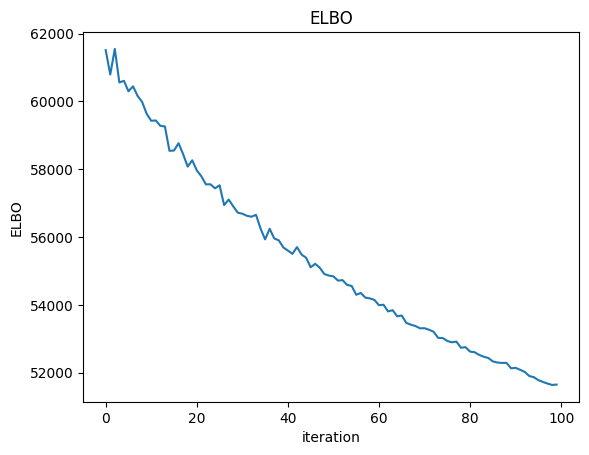

       policy rate  reward rate  dec temp  habitual tendency  cached weight  \
0         0.435567     0.432356  1.724803           0.714775       3.024721   
1         0.233006     0.314241  1.976983           0.451947       1.643723   
2         0.703069     0.727449  4.014460           0.887693       3.594101   
3         0.336892     0.443591  3.161620           0.450989       2.398778   
4         0.726395     0.578560  6.791987           0.462689       1.825711   
...            ...          ...       ...                ...            ...   
93995     0.828691     0.766350  7.545127           0.456338       1.634056   
93996     0.246287     0.590229  3.821116           0.481787       3.571717   
93997     0.097275     0.134830  3.618689           0.911981       4.058400   
93998     0.323958     0.379304  2.844369           0.821102       3.749883   
93999     0.444997     0.336688  3.282873           0.200022       2.603951   

       cached rate  subject  
0         0.328578   

<Figure size 640x480 with 0 Axes>

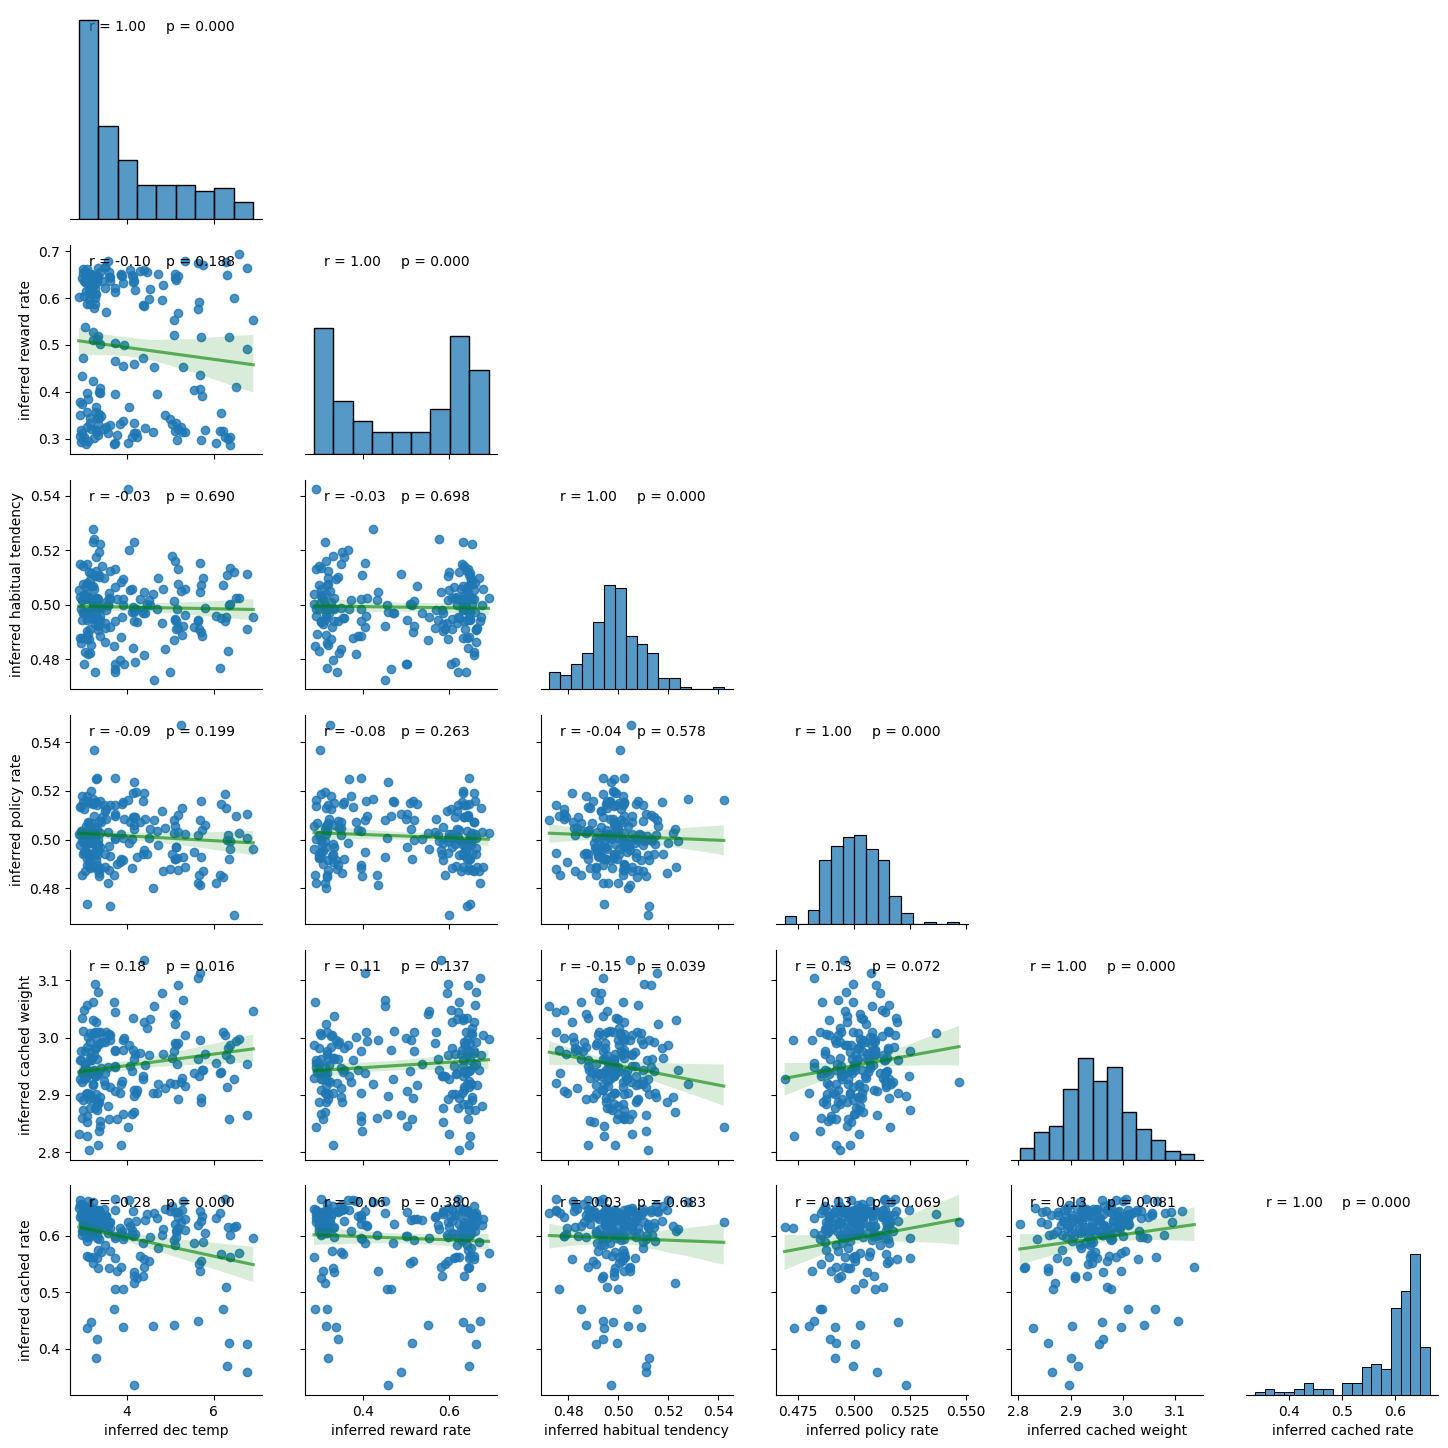

taking steps 101 to 200 out of total 600


Mean ELBO 48961.55: 100%|██████████| 100/100 [33:00<00:00, 19.81s/it]


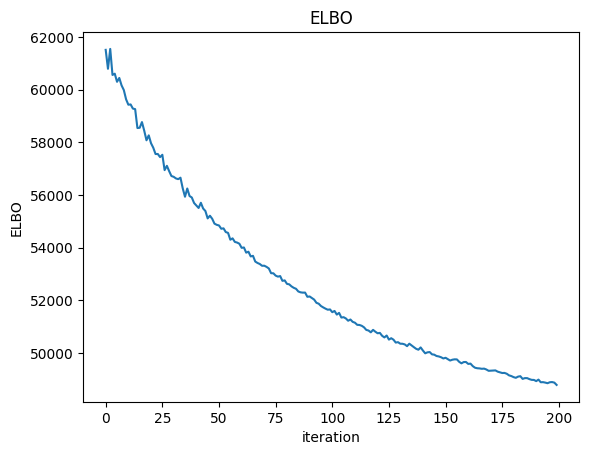

       policy rate  reward rate  dec temp  habitual tendency  cached weight  \
0         0.123677     0.535782  3.874638           0.128482       1.409817   
1         0.342745     0.457407  3.080009           0.078787       1.241105   
2         0.196186     0.378024  2.982275           0.182907       2.194754   
3         0.690667     0.271468  1.556518           0.833052       1.008527   
4         0.465800     0.627541  5.025705           0.455138       1.404606   
...            ...          ...       ...                ...            ...   
93995     0.438367     0.881094  7.154875           0.169819       3.379526   
93996     0.253184     0.416821  3.870591           0.914804       1.739893   
93997     0.574251     0.198777  4.379898           0.806422       1.654444   
93998     0.564418     0.632498  4.310318           0.601691       2.334337   
93999     0.450836     0.265578  2.981529           0.944366       1.813141   

       cached rate  subject  
0         0.668782   

<Figure size 640x480 with 0 Axes>

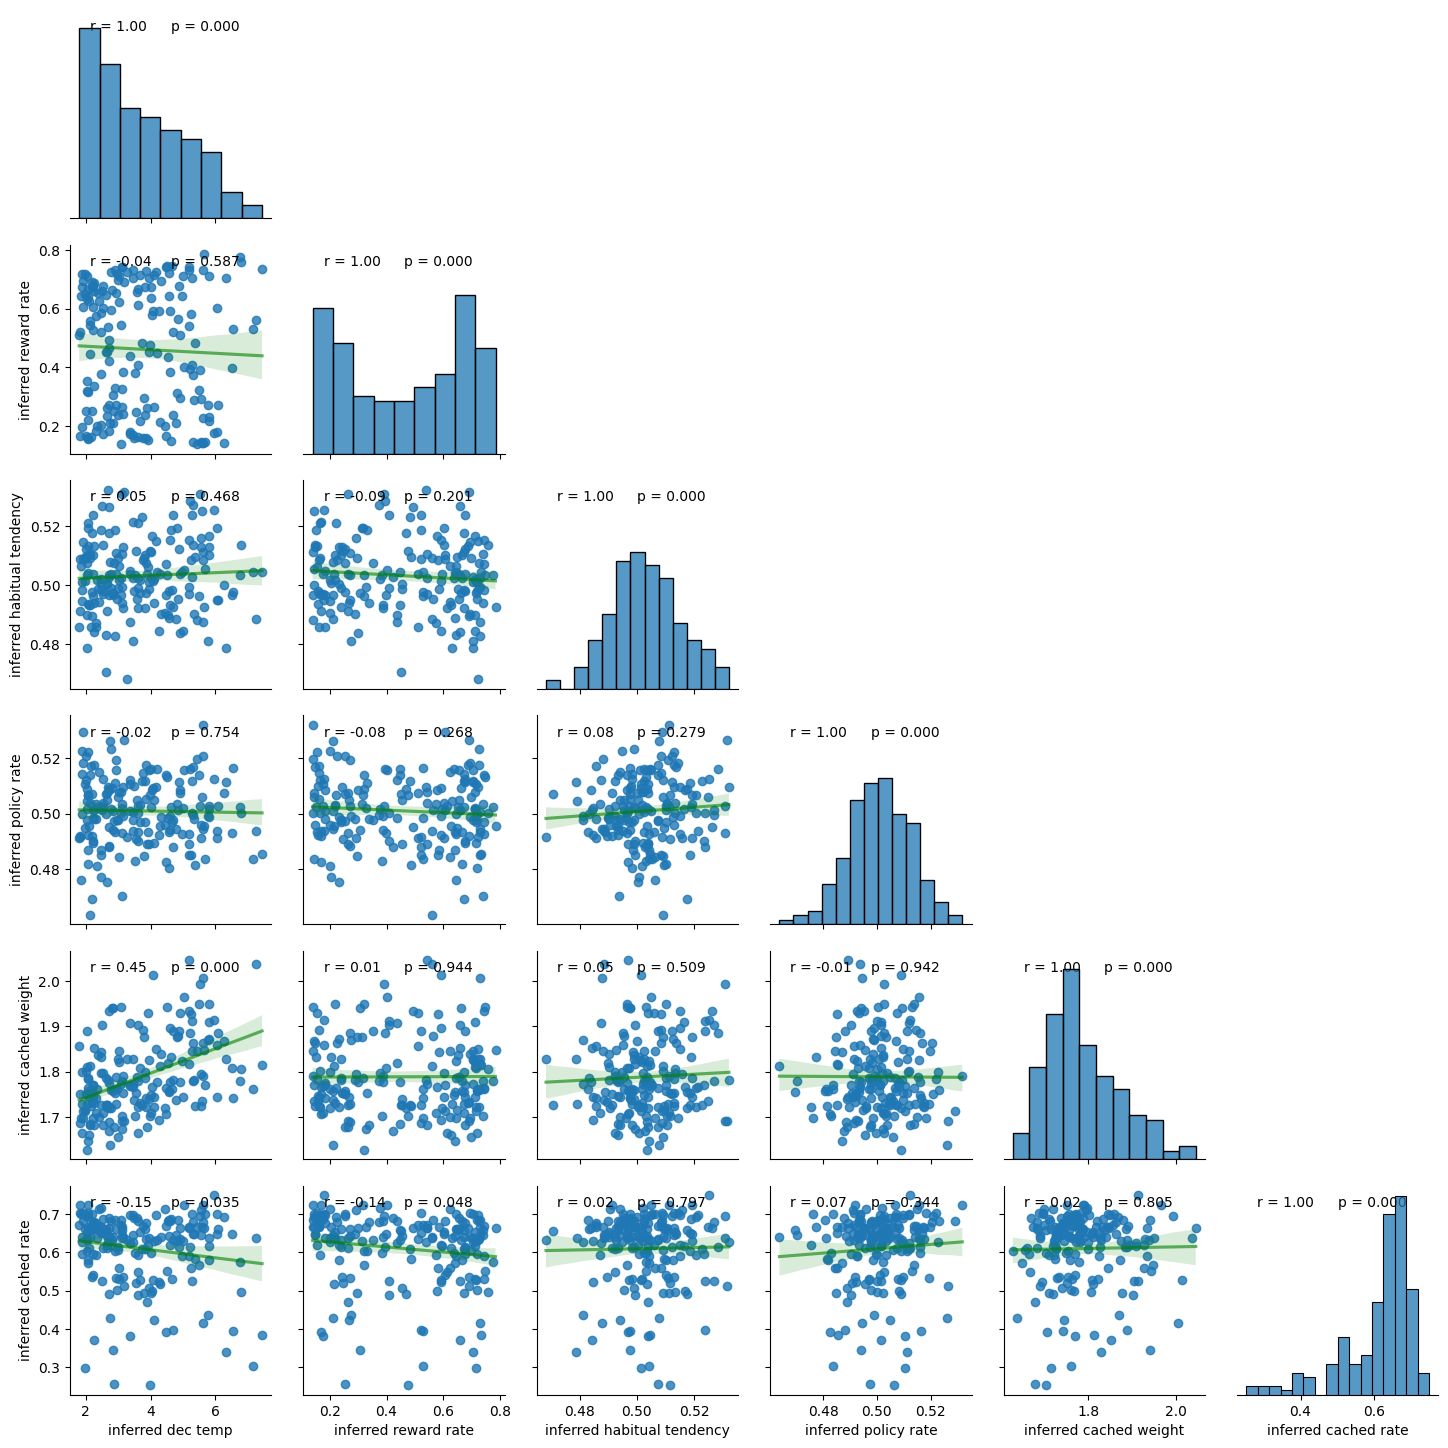

taking steps 201 to 300 out of total 600


Mean ELBO 47901.35: 100%|██████████| 100/100 [35:32<00:00, 21.33s/it]


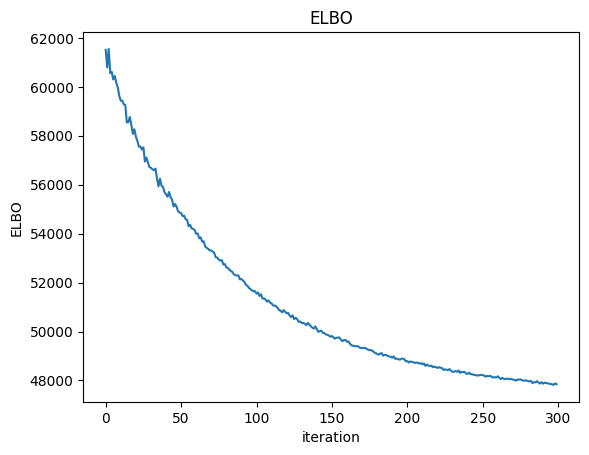

       policy rate  reward rate  dec temp  habitual tendency  cached weight  \
0         0.515853     0.531202  3.453175           0.850833       1.546299   
1         0.108306     0.564983  2.649215           0.360262       1.295161   
2         0.608613     0.765511  1.410243           0.358934       1.905380   
3         0.665798     0.264687  1.089547           0.474046       0.987492   
4         0.741293     0.568072  6.008912           0.613831       1.376430   
...            ...          ...       ...                ...            ...   
93995     0.846423     0.811012  6.079725           0.730135       1.360300   
93996     0.378247     0.355682  2.210738           0.269161       1.350330   
93997     0.267176     0.157147  4.920558           0.336031       1.757000   
93998     0.938847     0.518503  1.966763           0.412114       0.843806   
93999     0.203069     0.403291  3.582906           0.523681       1.659551   

       cached rate  subject  
0         0.873047   

<Figure size 640x480 with 0 Axes>

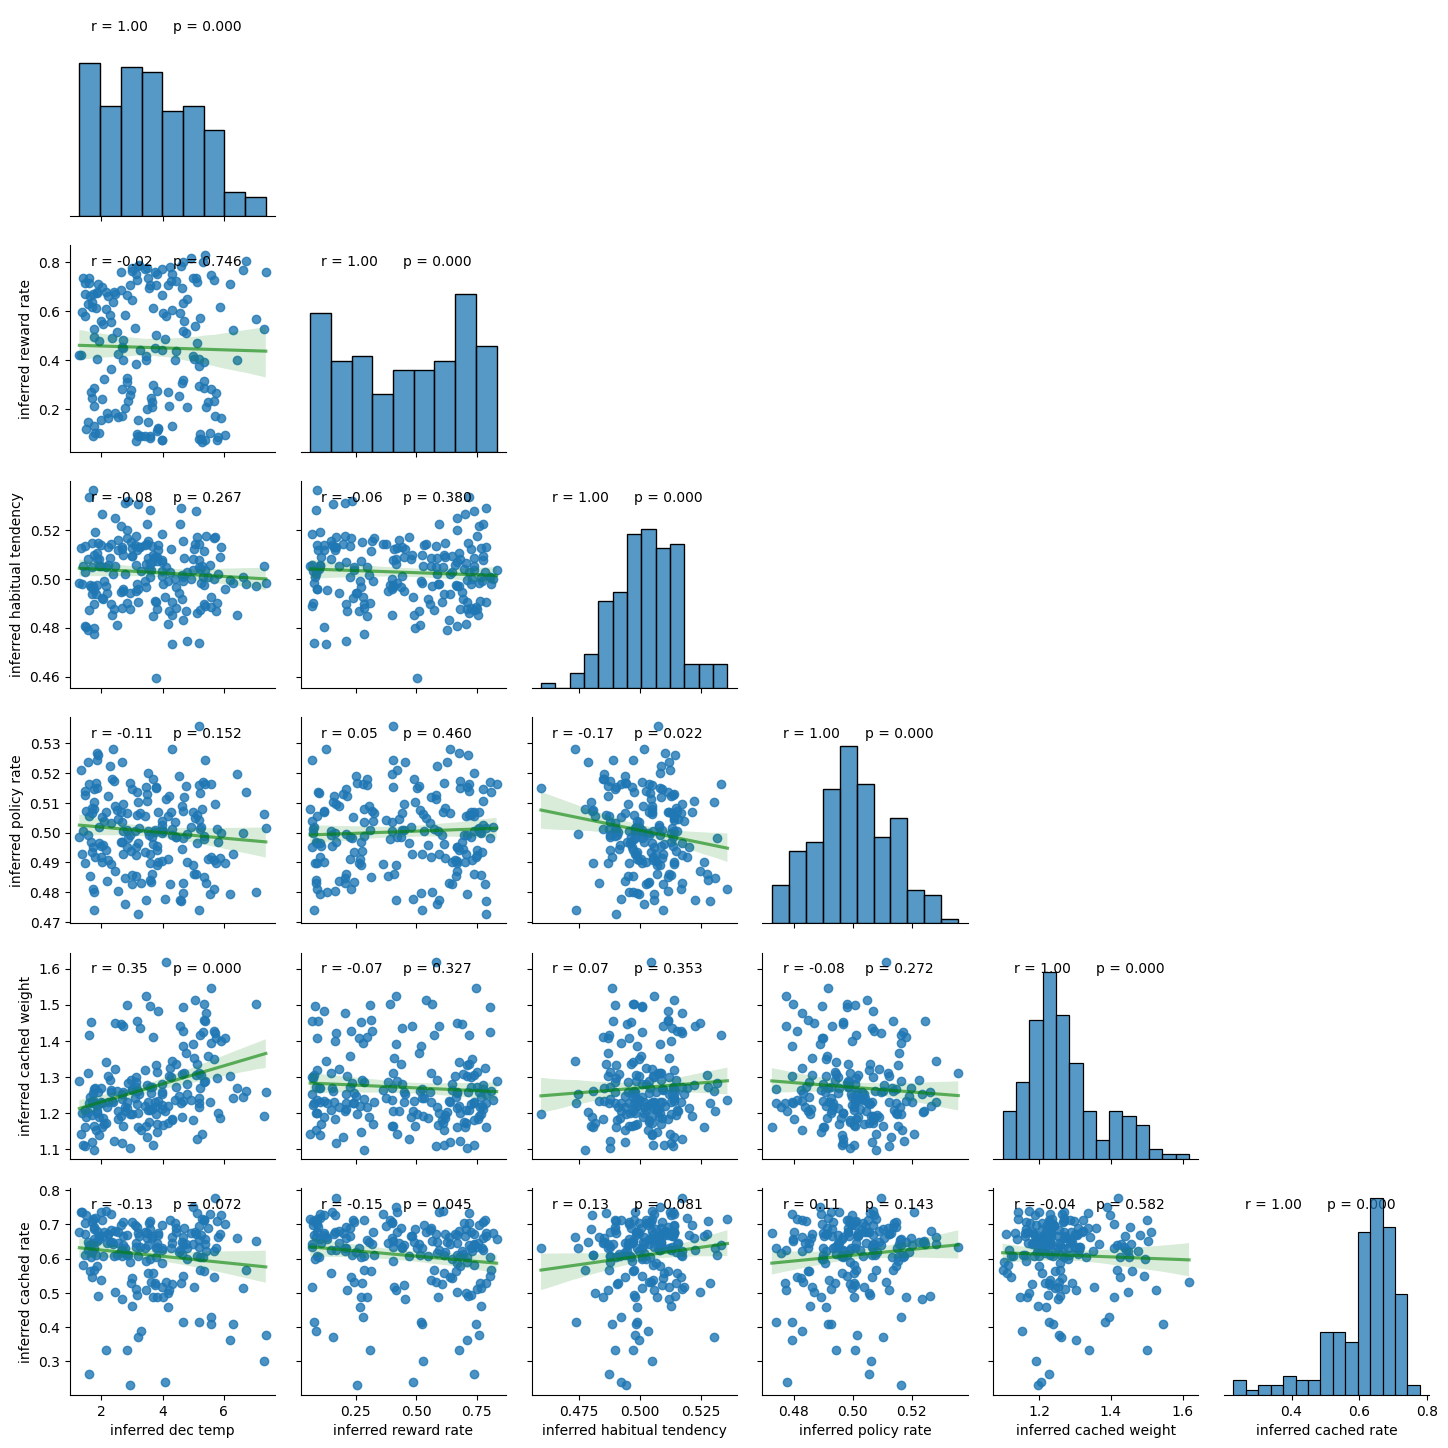

taking steps 301 to 400 out of total 600


Mean ELBO 47457.10: 100%|██████████| 100/100 [32:58<00:00, 19.79s/it]


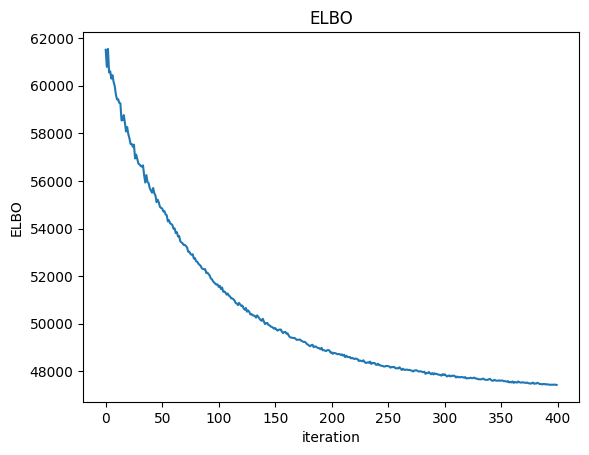

       policy rate  reward rate  dec temp  habitual tendency  cached weight  \
0         0.468910     0.592577  2.560830           0.922468       0.748122   
1         0.100569     0.509924  2.918361           0.854925       1.080018   
2         0.069125     0.970761  0.939515           0.386813       1.282670   
3         0.649076     0.216833  2.178793           0.216794       0.752423   
4         0.515635     0.672286  5.590842           0.543553       1.031349   
...            ...          ...       ...                ...            ...   
93995     0.167522     0.913321  6.167096           0.493697       0.859698   
93996     0.104360     0.335127  3.298592           0.341892       0.829521   
93997     0.109298     0.199094  4.480141           0.448393       0.924503   
93998     0.201296     0.229528  1.015083           0.590947       0.579976   
93999     0.587153     0.316871  2.040697           0.960621       0.786675   

       cached rate  subject  
0         0.414278   

<Figure size 640x480 with 0 Axes>

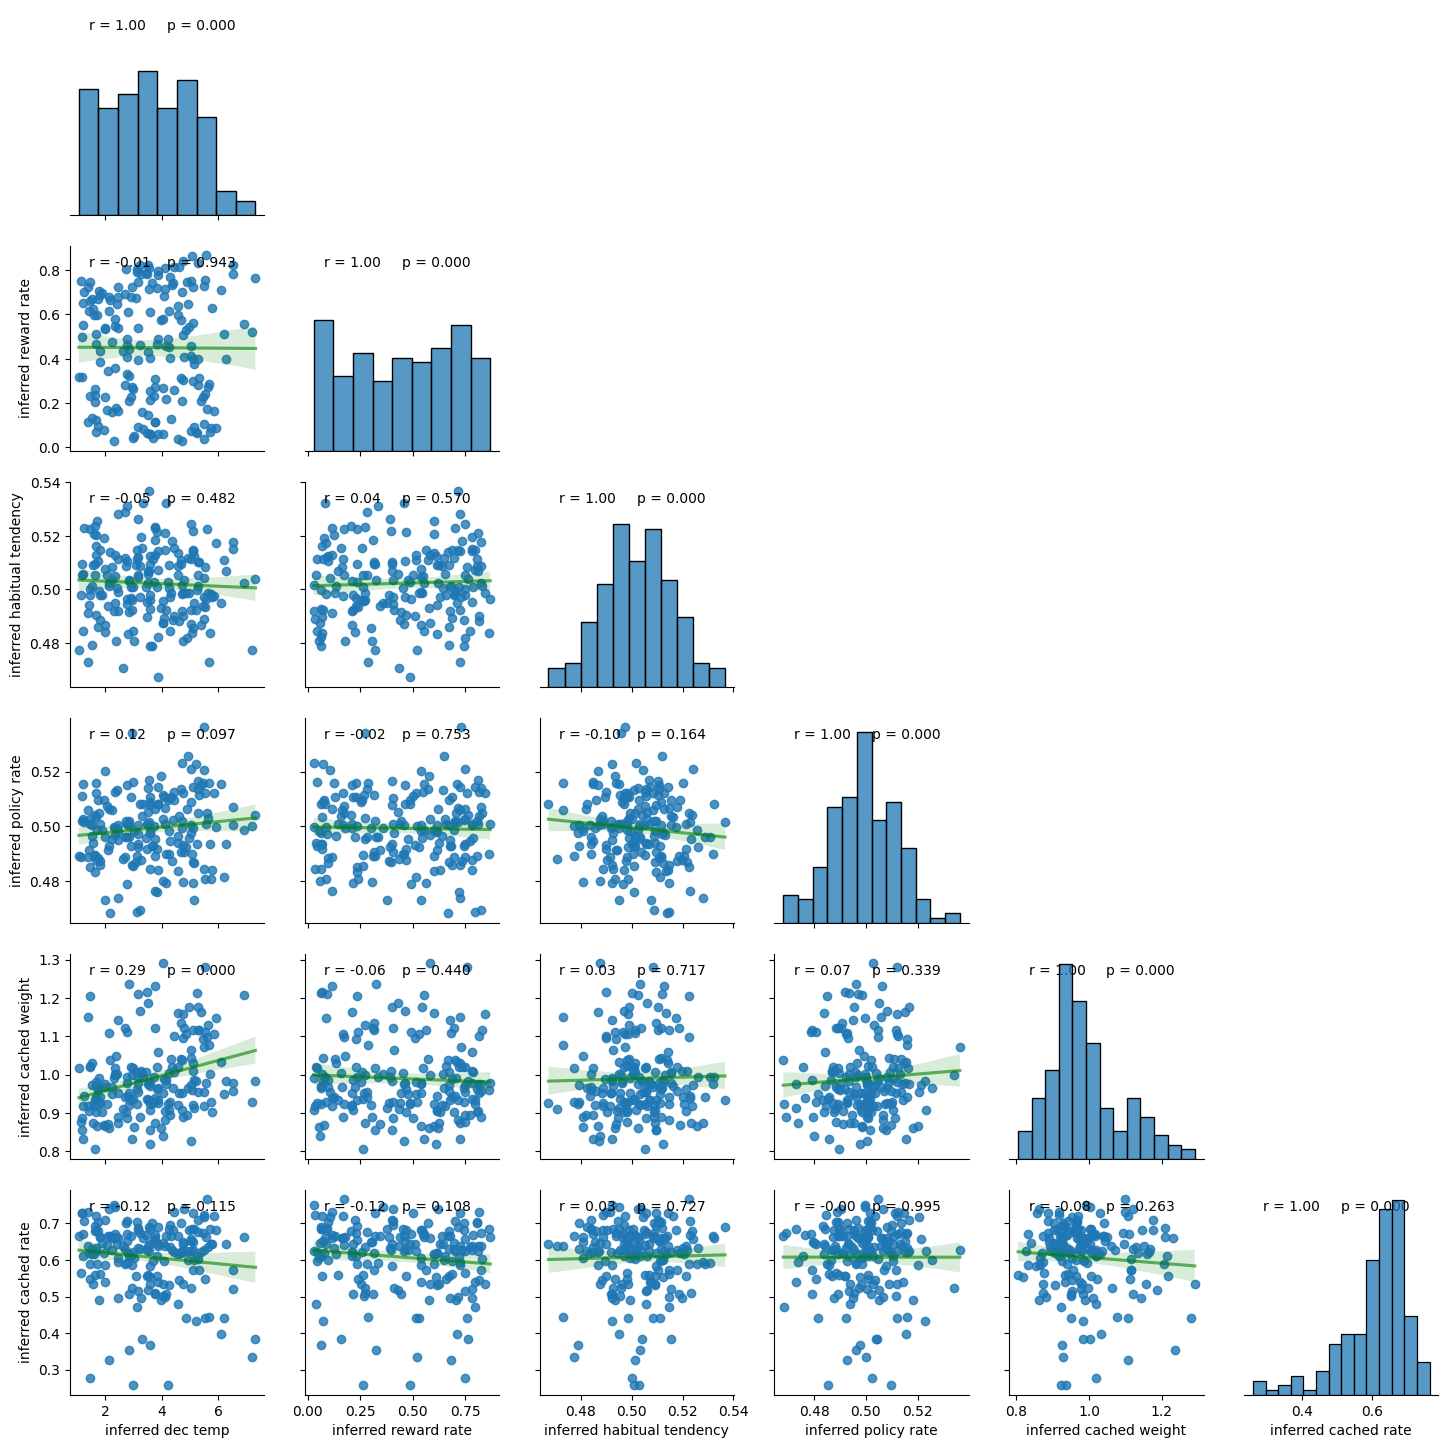

taking steps 401 to 500 out of total 600


Mean ELBO 47238.55: 100%|██████████| 100/100 [33:28<00:00, 20.09s/it]


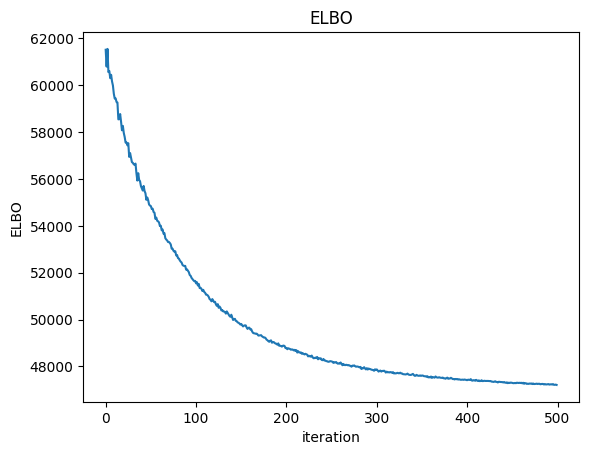

       policy rate  reward rate  dec temp  habitual tendency  cached weight  \
0         0.700837     0.431370  2.838729           0.217480       1.059348   
1         0.410976     0.533565  2.008948           0.742573       0.919842   
2         0.755913     0.964667  1.455682           0.456878       0.403358   
3         0.716313     0.154366  2.221012           0.468827       0.530637   
4         0.743728     0.668493  4.348711           0.291584       0.642751   
...            ...          ...       ...                ...            ...   
93995     0.175194     0.743780  5.265291           0.462702       0.793568   
93996     0.109730     0.550758  3.057015           0.133919       0.486304   
93997     0.452974     0.159742  4.811640           0.351158       0.519639   
93998     0.547816     0.510145  2.842854           0.765671       0.688878   
93999     0.194823     0.312397  2.179251           0.099624       0.519376   

       cached rate  subject  
0         0.843028   

<Figure size 640x480 with 0 Axes>

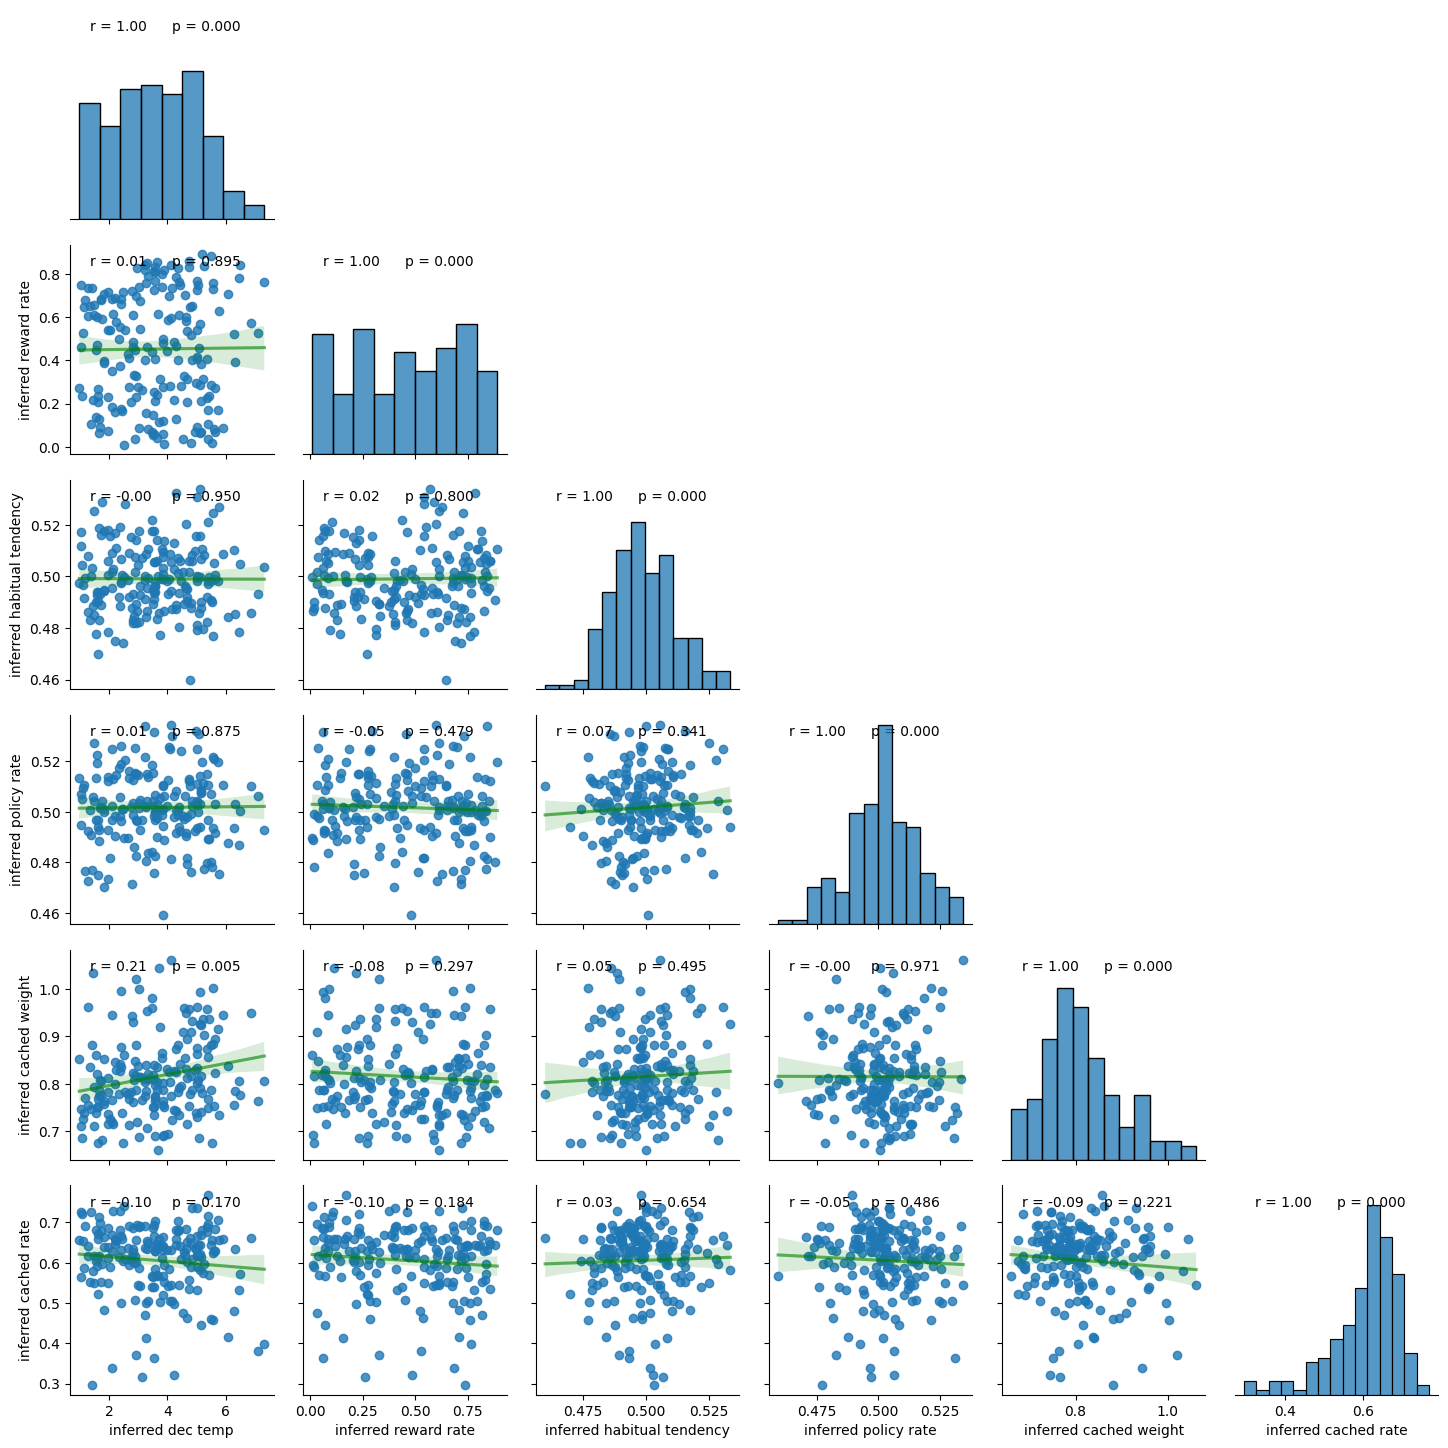

taking steps 501 to 600 out of total 600


Mean ELBO 47137.21: 100%|██████████| 100/100 [32:19<00:00, 19.39s/it]


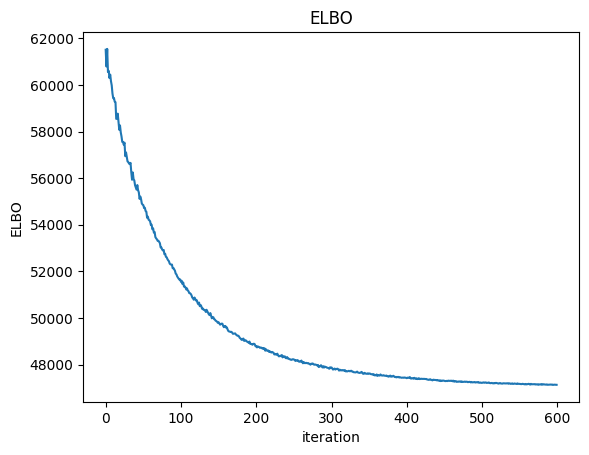

       policy rate  reward rate  dec temp  habitual tendency  cached weight  \
0         0.375799     0.414037  2.721273           0.681174       0.734333   
1         0.210577     0.423519  2.583881           0.271988       0.459779   
2         0.394355     0.730419  1.598628           0.771427       0.561516   
3         0.491622     0.254651  1.062223           0.704332       0.636745   
4         0.385108     0.622565  3.684576           0.835910       0.385763   
...            ...          ...       ...                ...            ...   
93995     0.215933     0.923078  5.079012           0.921350       0.602014   
93996     0.118446     0.517479  2.221511           0.063954       1.059250   
93997     0.376459     0.238320  3.948024           0.059105       0.698392   
93998     0.660169     0.235169  1.519457           0.964867       0.865558   
93999     0.324187     0.293988  2.354717           0.657355       0.822986   

       cached rate  subject  
0         0.785905   

<Figure size 640x480 with 0 Axes>

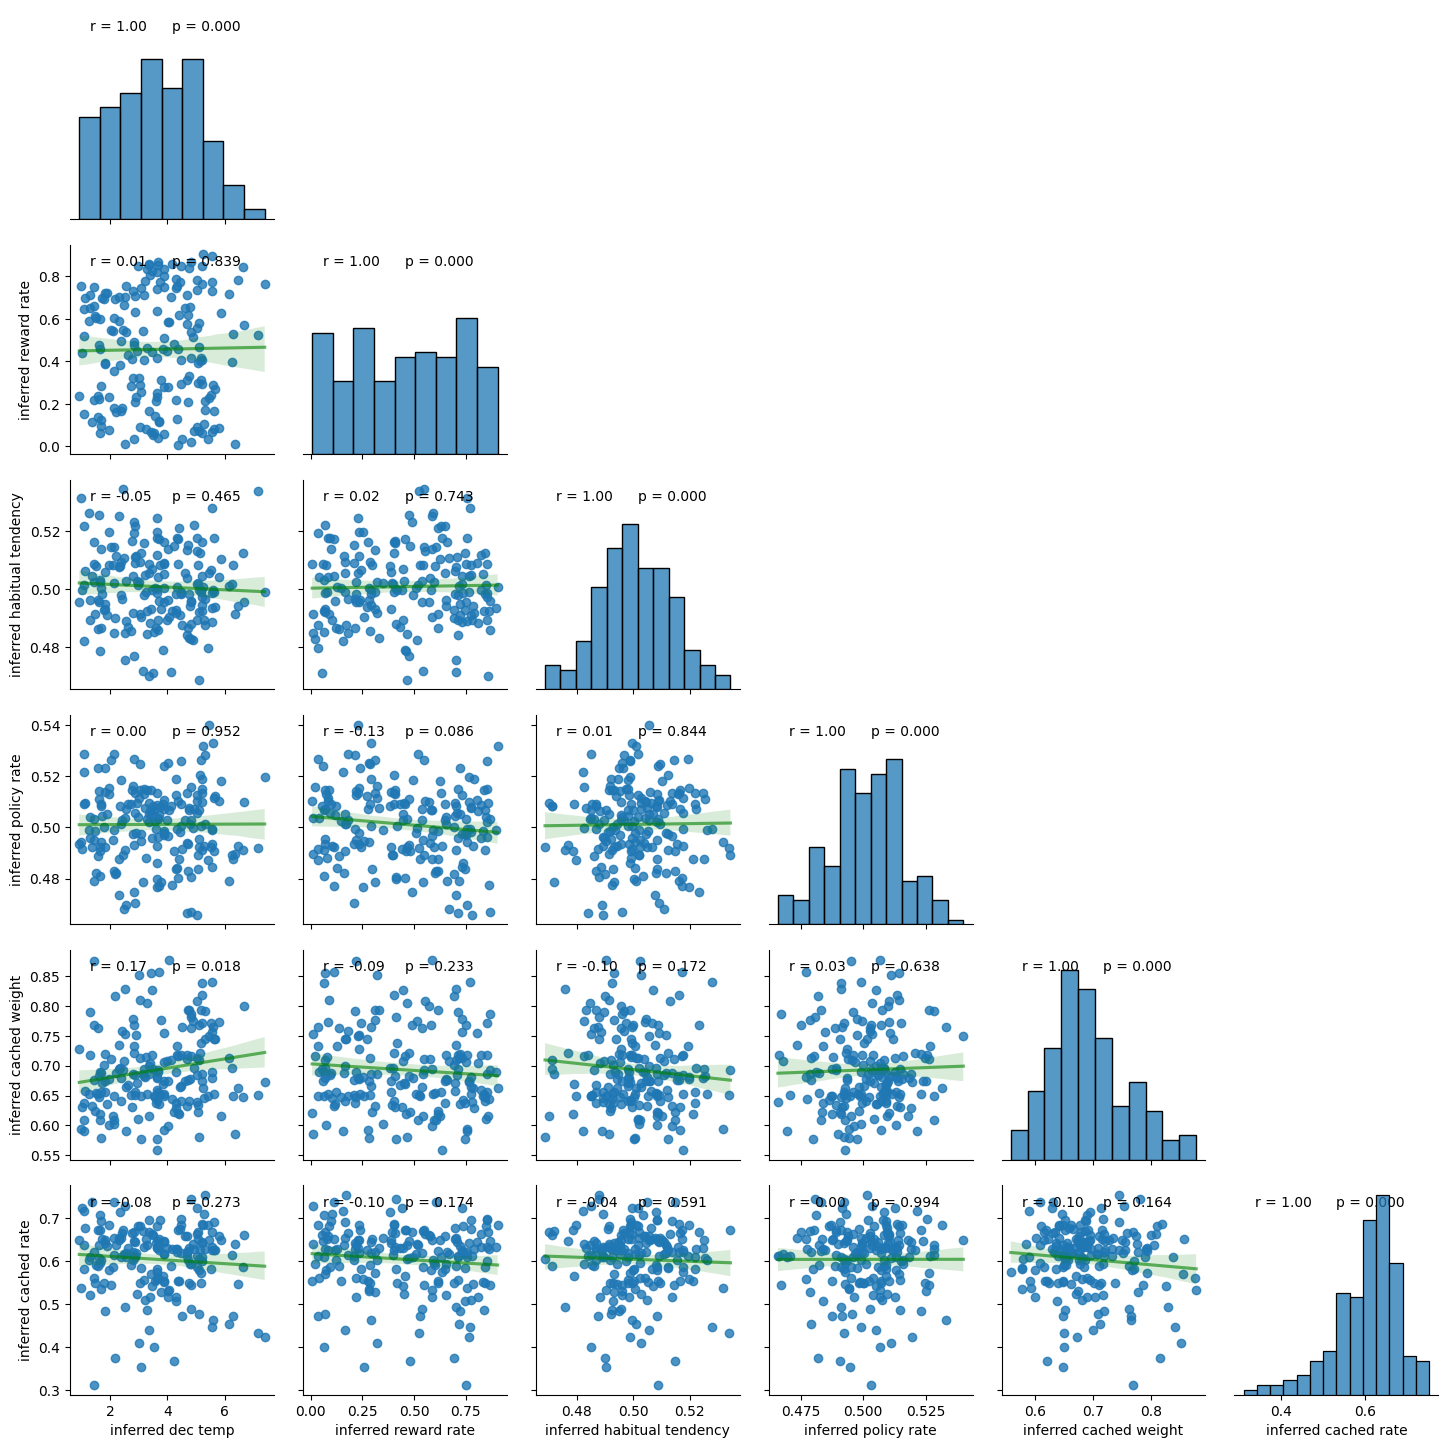

In [15]:
if run_inference:

    # remove old inference?
    remove_old = True

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, data["valid"], remove_old=remove_old)

    print('analyzing '+str(n_agents)+' data sets')

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    num_particles = 15


    print("this is inference using", type(inferrer))
    
    size_chunk = 100
    total_num_iter_so_far = 0

    for i in range(total_num_iter_so_far, num_steps, size_chunk):
        print('taking steps '+str(i+1)+' to '+str(i+size_chunk)+' out of total '+str(num_steps))

        fname_str = fname_base + str(total_num_iter_so_far+size_chunk)+'_'+str(n_agents)+'agents'

        iu.infer(inferrer, size_chunk, fname_str, num_particles, base_dir)
        total_num_iter_so_far += size_chunk

        inferrer.save_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

        inferrer.save_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

        # sample from posterior only at last time step and save results. Could be done at every step, if earlier posteriors are of interest, one can load the inferrer save and sample from that.
        mean_df, sample_df, locs_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir)#, true_vals=true_vals) 
        
        plt.figure()
        vars_of_interest = ["inferred "+name for name in param_names]
        f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,
                            plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                            grid_kws={"layout_pad": 1.5},
                            x_vars=vars_of_interest, y_vars=vars_of_interest)
        f.map(tu.annot_corrfunc)
        # for p, p_range in enumerate(param_ranges):
        #     f.axes[3,p].set_xlim(p_range)
        #     f.axes[p,0].set_ylim(p_range)
        plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
        plt.show()

<b>Or:</b> Set up agent and inference. Load past inference, decide whether to resample posterior or used stored samples

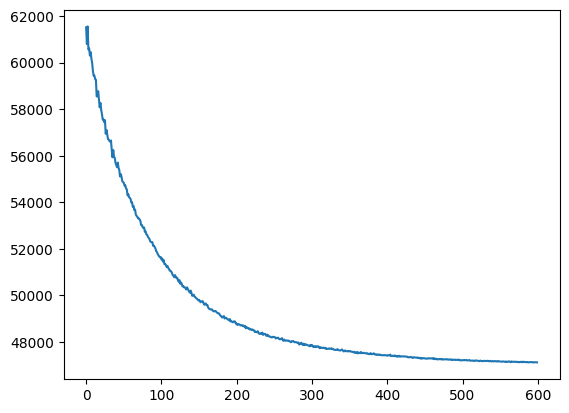

last ELBO: tensor(47128.4180)


In [16]:
if not run_inference:

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = True

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

plt.figure()
plt.plot(inferrer.loss)
plt.show()
print("last ELBO:", inferrer.loss[-1])

<Figure size 640x480 with 0 Axes>

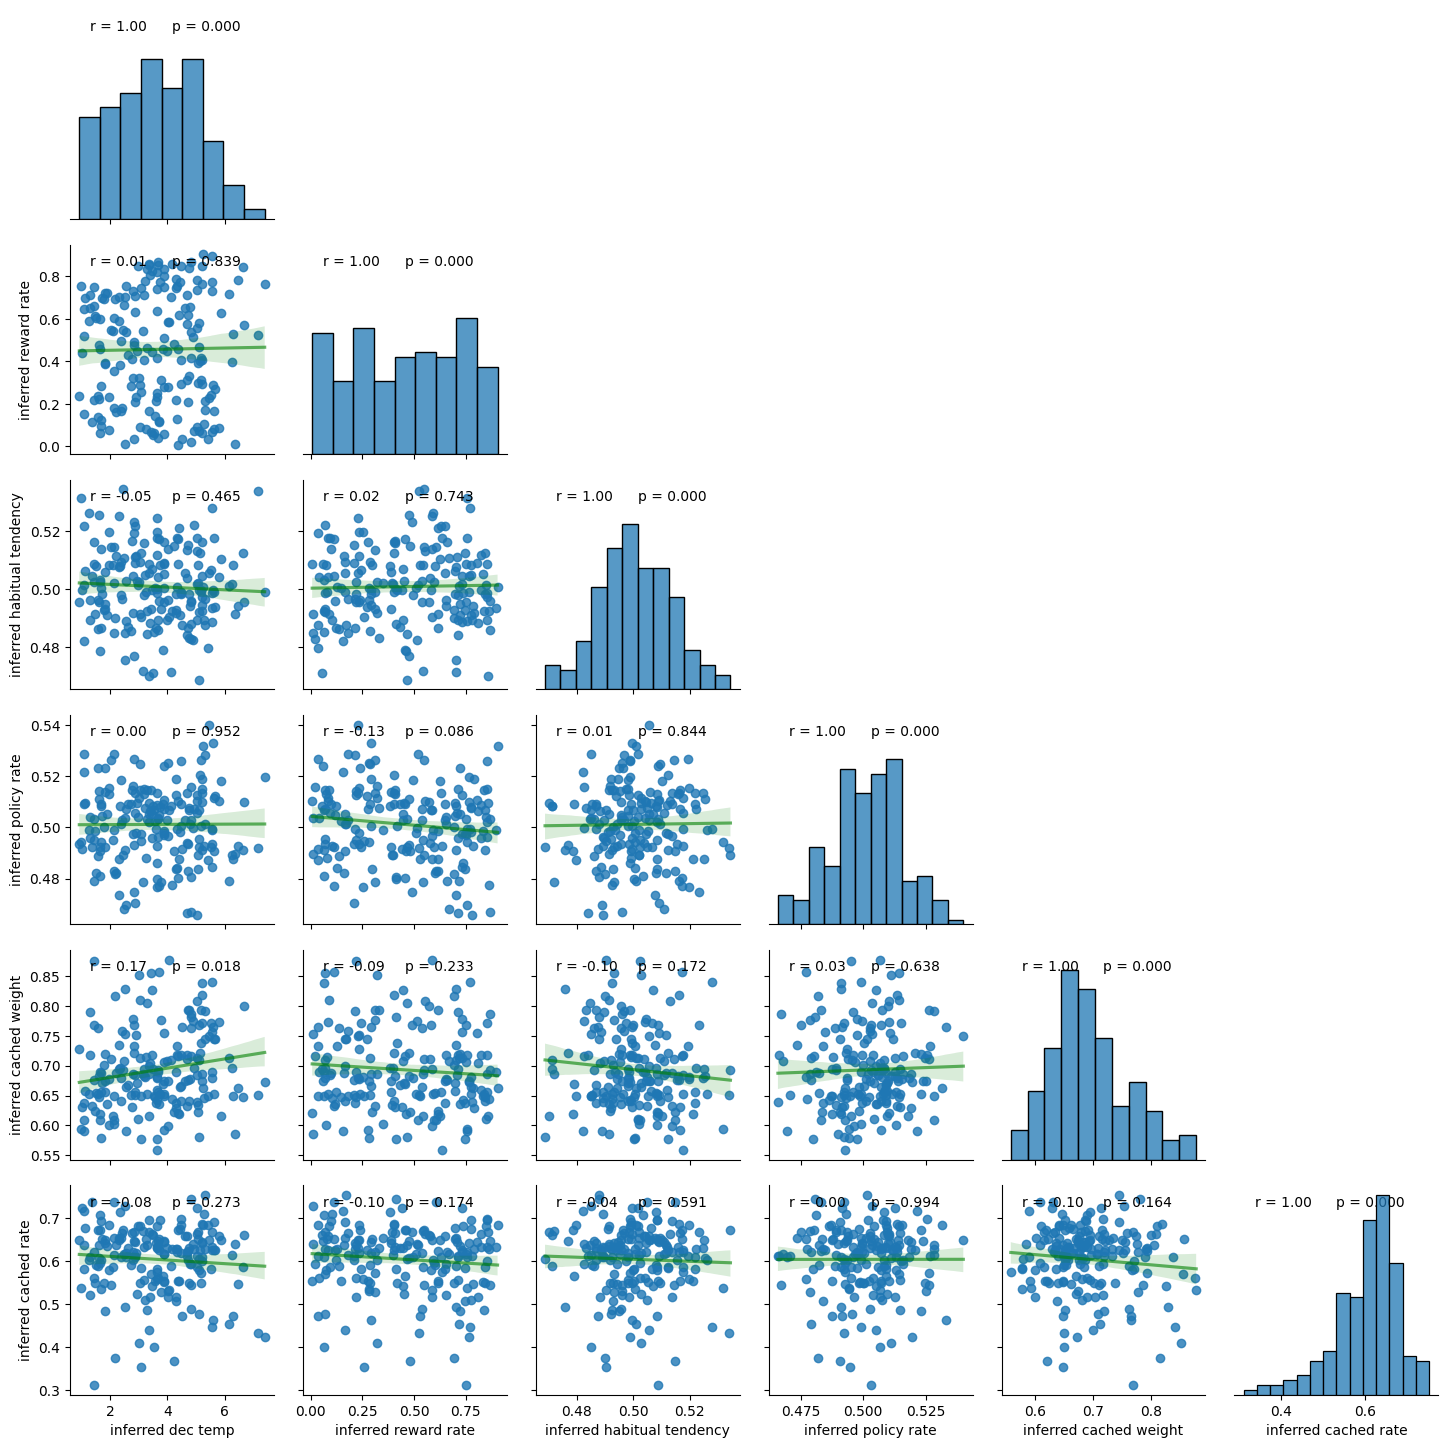

This is recovery for the twostage task using the Bayesian prior-based contextual control model(BCC_6pars_plan_habit_weight_cached_NO_context) with 188 agents.
The settings are: learn habit - True


In [17]:
plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    grid_kws={"layout_pad": 1.5},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
# for p, p_range in enumerate(param_ranges):
#     f.axes[3,p].set_xlim(p_range)
#     f.axes[p,0].set_ylim(p_range)
plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is recovery for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: learn habit - "+str(learn_habit))